In [ ]:
!pip install torch # torch
!pip install peft # necessary for finetuning of the large model via LoRA approach
!pip install bitsandbytes # necessary for quantiziation
!pip install evaluate # extension of the transformers library
!pip install datasets # extension of the transformers library
!pip install accelerate

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import pandas as pd
from datasets import Dataset, load_dataset
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding)

import bitsandbytes as bnb

import evaluate
import numpy as np

import random

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ag_news")
train_dataset = dataset["train"].shuffle(seed=43).select(range(100))
test_dataset = dataset["test"].shuffle(seed=43).select(range(100))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id  = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_ag_train = train_dataset.map(preprocess_function, batched=True)
tokenized_ag_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1", average="macro")
precision = evaluate.load("precision", average="macro")
recall = evaluate.load("recall", average="macro")

# Combine the individual metrics into a single metric
metric = evaluate.combine([accuracy, f1, precision, recall])

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  # Convert probabilities to predicted labels
    return metric.compute(predictions=predictions, references=labels)
    return results


In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enables 4-bit quantization
    bnb_4bit_use_double_quant=True,  # Use double quantization for potentially higher accuracy (optional)
    bnb_4bit_quant_type="nf4",  # Quantization type (specifics depend on hardware and library)
    bnb_4bit_compute_dtype=torch.bfloat16  # Compute dtype for improved efficiency (optional)
)


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=4,
    quantization_config=bnb_config,  # configuration for quantization
    device_map={"": 0}  # Optional dictionary specifying device mapping (single GPU with index 0 here)
)


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def find_linear_names(model):
    """
    This function identifies all linear layer names within a model that use 4-bit quantization.
    Args:
        model (torch.nn.Module): The PyTorch model to inspect.
    Returns:
        list: A list containing the names of all identified linear layers with 4-bit quantization.
    """
    cls = bnb.nn.Linear4bit

    # Set to store identified layer names
    lora_module_names = set()

    # Iterate through named modules in the model
    for name, module in model.named_modules():
        # Check if the current module is an instance of the 4-bit linear layer class
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

        # Special case: remove 'lm_head' if present
        if 'lm_head' in lora_module_names:
            lora_module_names.remove('lm_head')
    return list(lora_module_names)

# Example usage:
modules = find_linear_names(model)
print(modules)


['o_proj', 'v_proj', 'k_proj', 'up_proj', 'down_proj', 'q_proj', 'gate_proj']


In [ ]:
lora_config = LoraConfig(
    r=64,  # Reduction factor (lower r means more parameters in the adapter)
    lora_alpha=32,  # Dimensionality of the adapter projection
    target_modules=modules,  # List of modules to apply the LoRA adapter
    lora_dropout=0.05,  # Dropout rate for the adapter
    bias="none",  # Bias configuration for the adapter
    task_type="SEQ_CLS"  # Task type (sequence classification in this case)
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 167,788,544 || all params: 7,672,729,600 || trainable%: 2.1868


In [ ]:
training_args = TrainingArguments(
    output_dir="epoch_weights",  # Output directory for checkpoints
    learning_rate=2e-5,  # Learning rate for the optimizer
    per_device_train_batch_size=1,  # Batch size per device
    per_device_eval_batch_size=1,  # Batch size per device for evaluation
    num_train_epochs=5,  # Number of training epochs
    weight_decay=0.01,  # Weight decay for regularization
    evaluation_strategy='epoch',  # Evaluate after each epoch
    save_strategy="epoch",  # Save model checkpoints after each epoch
    load_best_model_at_end=True,  # Load the best model based on the chosen metric
    push_to_hub=False,  # Disable pushing the model to the Hugging Face Hub
    report_to="none",  # Disable logging to Weight&Bias
    metric_for_best_model='eval_loss')  # Metric for selecting the best model

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

trainer = Trainer(
    model=model,  # The LoRA-adapted model
    args=training_args,  # Training arguments
    train_dataset=tokenized_ag_train,  # Training dataset
    eval_dataset=tokenized_ag_test,  # Evaluation dataset
    tokenizer=tokenizer,  # Tokenizer for processing text
    data_collator=data_collator,  # Data collator for preparing batches
)

trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.425265
2,No log,1.047395
3,No log,1.157152
4,No log,1.031862
5,0.604700,1.040283


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_downlo

TrainOutput(global_step=500, training_loss=0.6047220458984375, metrics={'train_runtime': 977.3807, 'train_samples_per_second': 0.512, 'train_steps_per_second': 0.512, 'total_flos': 1059672489738240.0, 'train_loss': 0.6047220458984375, 'epoch': 5.0})

In [ ]:
preds = trainer.predict(tokenized_ag_test)
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

preds_flat = [np.argmax(x) for x in preds[0]]

In [ ]:
print(classification_report(test_dataset['label'], preds_flat))


              precision    recall  f1-score   support

           0       0.68      0.88      0.77        26
           1       0.90      0.78      0.84        23
           2       0.71      0.74      0.72        23
           3       0.77      0.61      0.68        28

    accuracy                           0.75       100
   macro avg       0.76      0.75      0.75       100
weighted avg       0.76      0.75      0.75       100



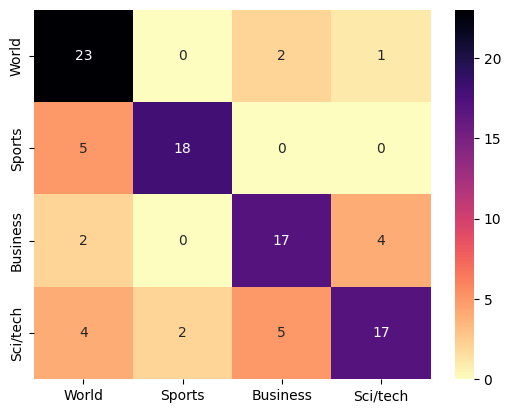

In [ ]:
import matplotlib as plt
import seaborn as sns
from matplotlib import pyplot as plt


# plot the heat map
sns.heatmap(
    confusion_matrix(test_dataset['label'], preds_flat),
    annot=True,
    xticklabels=['World','Sports','Business','Sci/tech'],
    yticklabels=['World','Sports','Business','Sci/tech'],
    cmap=plt.cm.magma_r
)
plt.show()